In [27]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
import numpy as np
import pandas as pd

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
from ESRNN.m4_data import *
from ESRNN.utils_evaluation import evaluate_prediction_owa
from ESRNN.utils_visualization import plot_grid_prediction

In [3]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name="Hourly",
                                                               directory="../data/M4",
                                                               num_obs=414)

In [4]:
y_train_df

unique_id                  ds        y
0             H1 1970-01-01 00:00:00    605.0
1             H1 1970-01-01 01:00:00    586.0
2             H1 1970-01-01 02:00:00    586.0
3             H1 1970-01-01 03:00:00    559.0
4             H1 1970-01-01 04:00:00    511.0
...          ...                 ...      ...
353495       H99 1970-01-29 23:00:00  27926.0
353496       H99 1970-01-30 00:00:00  26744.0
353497       H99 1970-01-30 01:00:00  25829.0
353498       H99 1970-01-30 02:00:00  25421.0
353499       H99 1970-01-30 03:00:00  23252.0

[353500 rows x 3 columns]

In [5]:
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353500 entries, 0 to 353499
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   unique_id  353500 non-null  object        
 1   ds         353500 non-null  datetime64[ns]
 2   y          353500 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.1+ MB


In [6]:
df = pd.DataFrame()

In [7]:
df['time_idx'] = (y_train_df['ds'] - y_train_df['ds'].min()).dt.total_seconds() // 3600
df['time_idx'] = df['time_idx'].astype(int)

In [8]:
df['unique_id'] = y_train_df['unique_id']
df['y'] = y_train_df['y']
df

time_idx unique_id        y
0              0        H1    605.0
1              1        H1    586.0
2              2        H1    586.0
3              3        H1    559.0
4              4        H1    511.0
...          ...       ...      ...
353495       695       H99  27926.0
353496       696       H99  26744.0
353497       697       H99  25829.0
353498       698       H99  25421.0
353499       699       H99  23252.0

[353500 rows x 3 columns]

In [9]:
max_encoder_length = 24*7
max_prediction_length = 48

In [10]:
cutoffs = df.groupby('unique_id')['time_idx'].transform(lambda x: x.max() - max_prediction_length)


In [11]:
cutoffs

0         651
1         651
2         651
3         651
4         651
         ... 
353495    651
353496    651
353497    651
353498    651
353499    651
Name: time_idx, Length: 353500, dtype: int32

In [12]:
training_data = df[df['time_idx'] <= cutoffs]

In [13]:
training_data

time_idx unique_id        y
0              0        H1    605.0
1              1        H1    586.0
2              2        H1    586.0
3              3        H1    559.0
4              4        H1    511.0
...          ...       ...      ...
353447       647       H99  23468.0
353448       648       H99  22524.0
353449       649       H99  22090.0
353450       650       H99  21857.0
353451       651       H99  20466.0

[333628 rows x 3 columns]

In [14]:
df[df['unique_id']=='H1']

time_idx unique_id      y
0           0        H1  605.0
1           1        H1  586.0
2           2        H1  586.0
3           3        H1  559.0
4           4        H1  511.0
..        ...       ...    ...
695       695        H1  790.0
696       696        H1  784.0
697       697        H1  752.0
698       698        H1  739.0
699       699        H1  684.0

[700 rows x 3 columns]

In [15]:
training_data[training_data['unique_id']=='H1']

time_idx unique_id      y
0           0        H1  605.0
1           1        H1  586.0
2           2        H1  586.0
3           3        H1  559.0
4           4        H1  511.0
..        ...       ...    ...
647       647        H1  897.0
648       648        H1  871.0
649       649        H1  831.0
650       650        H1  813.0
651       651        H1  749.0

[652 rows x 3 columns]

In [16]:
max_encoder_length = 7*24
max_prediction_length = 48

training = TimeSeriesDataSet(
    training_data[training_data['unique_id']=='H1'],
    time_idx="time_idx",
    target="y",
    group_ids=["unique_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    # static_categoricals=['unique_id'],
    # add_relative_time_idx=True,
    # add_target_scales=True,
    # add_encoder_length=True,
)

In [17]:
batch_size = 64

validation = TimeSeriesDataSet.from_dataset(training, df[df['unique_id']=='H1'], predict=True, stop_randomization=True)

# train_dataloader = DataLoader(training, batch_size=batch_size, shuffle=False)
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=5, persistent_workers=True)
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=5, persistent_workers=True)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=5)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=5)

# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [18]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)


c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


tensor(145.6667, device='cuda:0')

In [19]:
# # configure network and trainer
# pl.seed_everything(42)
# trainer = pl.Trainer(
#     accelerator="cpu",
#     # clipping gradients is a hyperparameter and important to prevent divergance
#     # of the gradient for recurrent neural networks
#     gradient_clip_val=0.1,
# )


# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # not meaningful for finding the learning rate but otherwise very important
#     learning_rate=0.03,
#     hidden_size=8,  # most important hyperparameter apart from learning rate
#     # number of attention heads. Set to up to 4 for large datasets
#     attention_head_size=1,
#     dropout=0.1,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=8,  # set to <= hidden_size
#     loss=SMAPE(),
#     optimizer="Ranger"
#     # reduce learning rate if no improvement in validation loss after x epochs
#     # reduce_on_plateau_patience=1000,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


In [20]:
# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=500,
#     accelerator="cuda",
#     enable_model_summary=True,
#     gradient_clip_val=0.1,
#     limit_train_batches=50,  # coment in for training, running valiation every 30 batches
#     # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
# )

# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.03,
#     hidden_size=16,
#     attention_head_size=2,
#     dropout=0.1,
#     hidden_continuous_size=8,
#     loss=SMAPE(),
#     log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
#     optimizer="Ranger",
#     reduce_on_plateau_patience=4,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


In [21]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    # callbacks=[lr_logger, early_stop_callback],
    logger=False,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=SMAPE(),
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 13.9k


c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [22]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 0     
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0     
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0     
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 4:   0%|          | 0/6 [00:06<?, ?it/s] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4:   0%|          | 0/6 [00:06<?, ?it/s]


In [26]:
predictions = tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
predictions
MAE()(predictions.output, predictions.y)


AttributeError: 'list' object has no attribute 'output'

In [23]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[]

In [25]:
tft.eval()

TemporalFusionTransformer(
  	"attention_head_size":               2
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            8
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       16
  	"learning_rate":                     0.03
  	"log_gradient_flow":                 False
  	"log_interval":                      -1
  	"log_val_interval":                  -1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              SMAPE()
  	"lstm_layers":                       1
  	"max_encoder_length":                168
  	"monotone_constaints":               {}
  	"optimizer":                         Ranger
  	"optimizer_pa

In [26]:
predictions = tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
predictions

c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


[]

c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does no

suggested learning rate: 0.013489628825916528


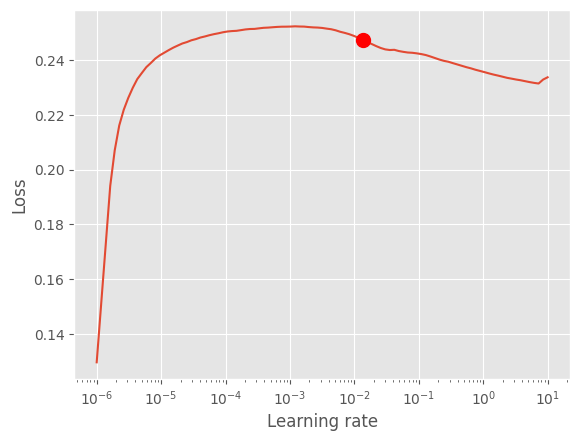

C:\Users\sonng\AppData\Local\Temp\ipykernel_30248\1913878069.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
